In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [ ]:
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
# !unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: h

load data

In [23]:
# path='hmnist_28_28_RGB.csv'
path= r'hmnist_28_28_RGB/hmnist_28_28_RGB.csv'
df=pd.read_csv(path)
df.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2353 entries, pixel0000 to label
dtypes: int64(2353)
memory usage: 179.8 MB


Shuffle the dataset

In [25]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0         69         54         55        127        104        100   
1        230        158        176        236        164        185   
2        254        216        235        254        214        229   
3        159        142        153        164        151        162   
4        245        171        178        246        172        183   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        162        132        128        175  ...         94         72   
1        239        167        189        241  ...        229        168   
2        254        211        231        255  ...        254        192   
3        171        161        169        175  ...        171        151   
4        246        173        183        247  ...        243        175   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0         73         30         21         23         18         13   
1        183        230        170        184        229        168   
2        196        254        199        209        254        205   
3        165        167        144        154        163        138   
4        174        241        174        173        240        172   

   pixel2351  label  
0         11      4  
1        182      4  
2        225      4  
3        147      2  
4        171      4  

[5 rows x 2353 columns]

Split the dataset into training and testing sets

In [26]:
X = df.drop(['label'], axis=1)
y = df['label']

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape X_train: {x_train.shape} and y_train: {y_train.shape}")
print(f"Shape X_test: {x_test.shape} and y_test: {y_test.shape}")

Shape X_train: (8012, 2352) and y_train: (8012,)
Shape X_test: (2003, 2352) and y_test: (2003,)


Normalize the pixel values

In [29]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Reshape the data

In [30]:
x_train = np.array(x_train).reshape(-1, 28, 28, 3)
x_test = np.array(x_test).reshape(-1, 28, 28, 3)

Convert labels to categorical format

In [31]:
df.label.unique()

array([4, 2, 1, 6, 0, 5, 3], dtype=int64)

In [32]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=7)

Visualize some images from the training set

In [33]:
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axes[i].imshow(x_train[i])
    axes[i].set_title(f"Label: {np.argmax(y_train[i])}")
    axes[i].axis('off')
plt.show()

Data augmentation

In [34]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)


# Build Model

In [35]:
model = Sequential([
    Conv2D(64, kernel_size=(3,3), input_shape=(28, 28, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 128)        

# Model Training

In [37]:
callback_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callback_lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001)

history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    validation_data=(x_test, y_test),
                    epochs=50,
                    callbacks=[callback_early_stopping, callback_checkpoint, callback_lr_reduction])
history.history

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 1.7784 - accuracy: 0.4769
Epoch 1: val_accuracy improved from -inf to 0.04593, saving model to best_model.h5
126/126 [==============================] - 24s 176ms/step - loss: 1.7784 - accuracy: 0.4769 - val_loss: 2.5900 - val_accuracy: 0.0459 - lr: 0.0010
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 1.0952 - accuracy: 0.6367
Epoch 2: val_accuracy improved from 0.04593 to 0.10684, saving model to best_model.h5
126/126 [==============================] - 21s 164ms/step - loss: 1.0952 - accuracy: 0.6367 - val_loss: 3.1550 - val_accuracy: 0.1068 - lr: 0.0010
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.9390 - accuracy: 0.6747
Epoch 3: val_accuracy improved from 0.10684 to 0.16425, saving model to best_model.h5
126/126 [==============================] - 23s 181ms/step - loss: 0.9390 - accuracy: 0.6747 - val_loss: 1.6880 - val_accuracy: 0.1643 - lr: 0.0010
Epoch 4/50
126/1

{'loss': [1.7784485816955566,
  1.095157265663147,
  0.9390479326248169,
  0.8705573081970215,
  0.7981514930725098,
  0.7745976448059082,
  0.7503518462181091,
  0.7324804067611694,
  0.7233145833015442,
  0.7114066481590271,
  0.70952969789505,
  0.6896713376045227,
  0.6808022260665894,
  0.6617134809494019,
  0.6475527286529541,
  0.6501785516738892,
  0.6436651945114136,
  0.6408726572990417,
  0.6422663927078247,
  0.637448787689209,
  0.6198766231536865,
  0.6144365072250366,
  0.6165635585784912,
  0.6010856628417969,
  0.6086999177932739,
  0.6054689884185791,
  0.603720486164093,
  0.5940512418746948,
  0.5905753970146179,
  0.584419310092926,
  0.5795164704322815,
  0.5931452512741089,
  0.579289972782135,
  0.5780831575393677,
  0.5768256187438965,
  0.575692892074585,
  0.5739516019821167,
  0.5695541501045227,
  0.5668424963951111,
  0.5597063302993774,
  0.5582877397537231,
  0.5560883283615112],
 'accuracy': [0.4769096374511719,
  0.6366699934005737,
  0.674737870693206

Model Evaluation

In [38]:
model.load_weights('best_model.h5')
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Loss: {loss}, Accuracy: {acc}")

63/63 - 1s - loss: 0.6104 - accuracy: 0.7793 - 1s/epoch - 21ms/step
Loss: 0.6103577613830566, Accuracy: 0.7793310284614563


In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

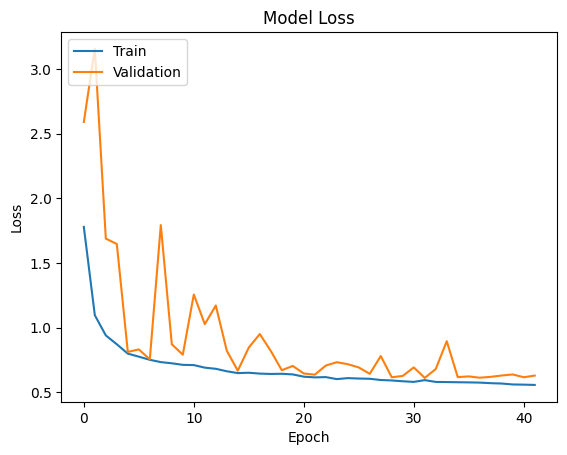

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [42]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
cm

63/63 [==============================] - 2s 21ms/step


array([[  27,   15,   11,    0,    8,    0,    8],
       [   7,   51,    4,    1,   21,    3,    5],
       [  10,   12,   79,    0,   76,    0,   36],
       [   1,    7,    1,    6,   10,    0,    1],
       [   3,    6,   19,    4, 1249,    1,   52],
       [   0,    1,    0,    0,    6,   21,    0],
       [   5,    3,   10,    0,   95,    0,  128]], dtype=int64)

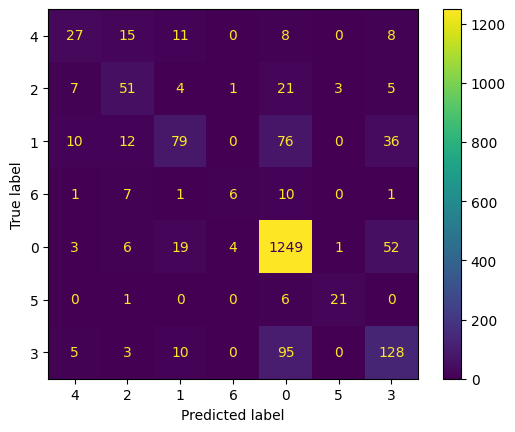

In [43]:
cmd = ConfusionMatrixDisplay(cm, display_labels=df.label.unique())
cmd.plot()

In [44]:
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")

Final Training Accuracy: 79.17%
Final Validation Accuracy: 76.29%


Finally save model

In [41]:
model.save('best_model.h5')

Model Testing

Finally you can replace numbers of output with names

In [45]:
# # reference: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/discussion/183083
# classes={
#     0:('akiec', 'actinic keratoses and intraepithelial carcinomae'),

#     1:('bcc' , 'basal cell carcinoma'),

#     2:('bkl', 'benign keratosis-like lesions'),

#     3:('df', 'dermatofibroma'),

#     4:('nv', ' melanocytic nevi'),

#     5:('vasc', ' pyogenic granulomas and hemorrhage'),

#     6:('mel', 'melanoma'),
# }